In [20]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [21]:
data = pd.read_csv("clean_data.csv")
data.head()

,Unnamed: 0,review,sentiment
0,169473,"Hadn't had this door handle a week, give also ...",negative
1,94275,Poor quality. Never mad ep,negative
2,61137,After reading a lot of the reviews I was glad ...,positive
3,51120,After less than 5 months the filter blew the e...,negative
4,185881,This is for the dryer only. The first load wa...,negative


In [22]:
data.isnull().sum()

Unnamed: 0    0
review        0
sentiment     0
dtype: int64

In [23]:
data=data.drop(columns=['Unnamed: 0'])

In [24]:
data.sentiment.value_counts()

negative    110981
positive    110981
Name: sentiment, dtype: int64

In [25]:
data.sentiment = [0 if i=="negative" else 1 for i in data.sentiment.values]

In [26]:
data

,review,sentiment
0,"Hadn't had this door handle a week, give also ...",0
1,Poor quality. Never mad ep,0
2,After reading a lot of the reviews I was glad ...,1
3,After less than 5 months the filter blew the e...,0
4,This is for the dryer only. The first load wa...,0
...,...,...
221957,The drainer is not too big so it doesn't take ...,0
221958,Smaller than expected but otherwise fine.,1
221959,There needs to be a way to stop the incessant ...,1
221960,Definitely off my list of replacement filters....,0


In [27]:
##data_pos = data[data['sentiment']=="positive"]

In [28]:
#data_nag = data[data['sentiment']=="negative"]

In [29]:
#data_pos2=data_pos[:110981]

In [33]:
#frames = [data_pos2, data_nag]
#data2=pd.concat(frames)


In [34]:
#data2

In [35]:
##data2.sentiment.value_counts()

In [36]:
#data2=data2.sample(frac = 1)

In [37]:
#data2=data2.sample(frac = 1)

In [38]:
#data2

In [74]:
#data2.to_csv('clean_data.csv')

In [39]:
#data2.sentiment.value_counts()

In [40]:
#data=data2

In [41]:
data.review[0]

"Hadn't had this door handle a week, give also $20 for it and it's already broken."

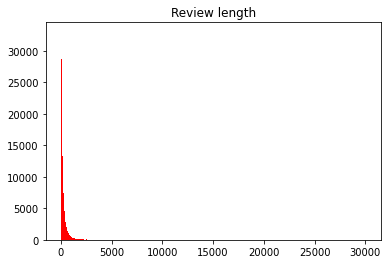

In [42]:
import matplotlib.pyplot as plt

review_len = data.review.str.len()
plt.hist(review_len, color="red", bins=1000)
plt.title("Review length")
plt.show()

In [43]:
def lower_text(text):
    text = " ".join(i.lower() for i in text.split())
    return text

In [44]:
from bs4 import BeautifulSoup

def remove_noise(text):
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    text = re.sub("\[[^]]*\]", "", text)
    return text

In [45]:
import string 

def remove_punc(text):
    tokens = text.split()
    re_punc = re.compile("[%s]"%re.escape(string.punctuation))
    tokens = [re_punc.sub("", w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    text = " ".join(tokens)
    
    return text

In [46]:
def preprocess_data(text):
    text = lower_text(text)
    text = remove_noise(text)
    text = remove_punc(text)
    
    return text

data.review = data.review.apply(preprocess_data)

C:\Users\Ibrahim\anaconda3\envs\lio\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\Ibrahim\anaconda3\envs\lio\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [47]:
data.head()

,review,sentiment
0,hadnt had this door handle a week give also fo...,0
1,poor quality never mad ep,0
2,after reading a lot of the reviews i was glad ...,1
3,after less than months the filter blew the end...,0
4,this is for the dryer only the first load was ...,0


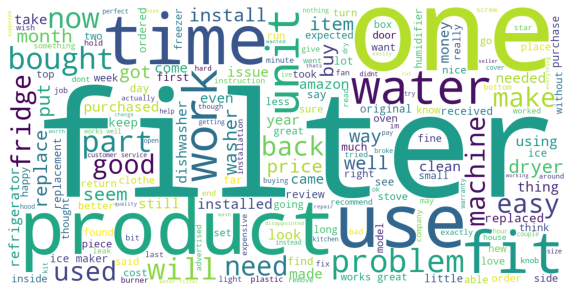

In [48]:
import wordcloud

text = " ".join(i for i in data.review)

wc = wordcloud.WordCloud(width=1200, height=600, background_color="white")
wc.generate(text)

plt.figure(figsize=[10, 10])
plt.imshow(wc)
plt.axis("off")
plt.show()

In [49]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

def create_corpus():
    corpus = []
    for x in data.review:
        for i in x.split():
            if i not in stop_words:           
                corpus.append(i)
    return corpus

corpus = create_corpus()

In [50]:
data.head()

,review,sentiment
0,hadnt had this door handle a week give also fo...,0
1,poor quality never mad ep,0
2,after reading a lot of the reviews i was glad ...,1
3,after less than months the filter blew the end...,0
4,this is for the dryer only the first load was ...,0


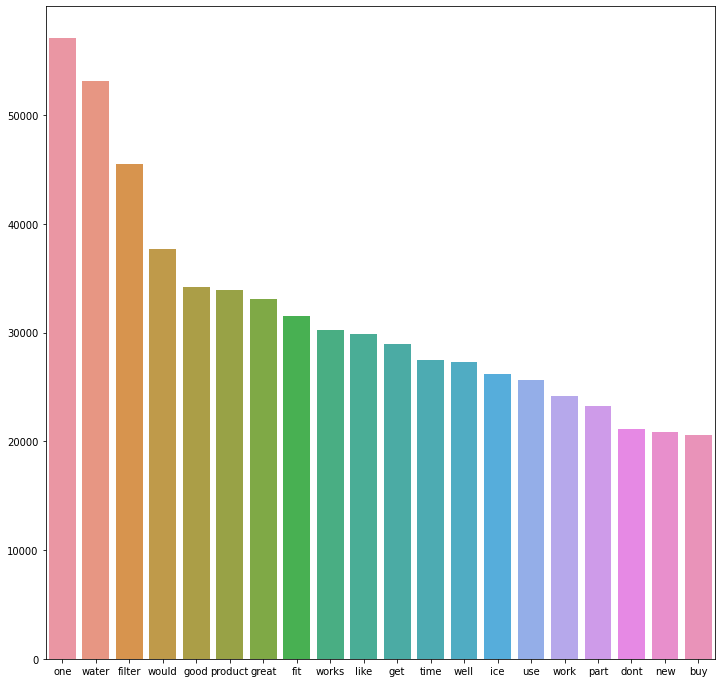

In [51]:
from collections import Counter
import seaborn as sns

counter = Counter(corpus)
most_words = counter.most_common()

words = []
counts = []

for word, count in most_words[:20]:
    if word not in stop_words:
        words.append(word)
        counts.append(count)

plt.figure(figsize=(12,12))
sns.barplot(x=words, y=counts)
plt.show()

In [52]:
data.head()

,review,sentiment
0,hadnt had this door handle a week give also fo...,0
1,poor quality never mad ep,0
2,after reading a lot of the reviews i was glad ...,1
3,after less than months the filter blew the end...,0
4,this is for the dryer only the first load was ...,0


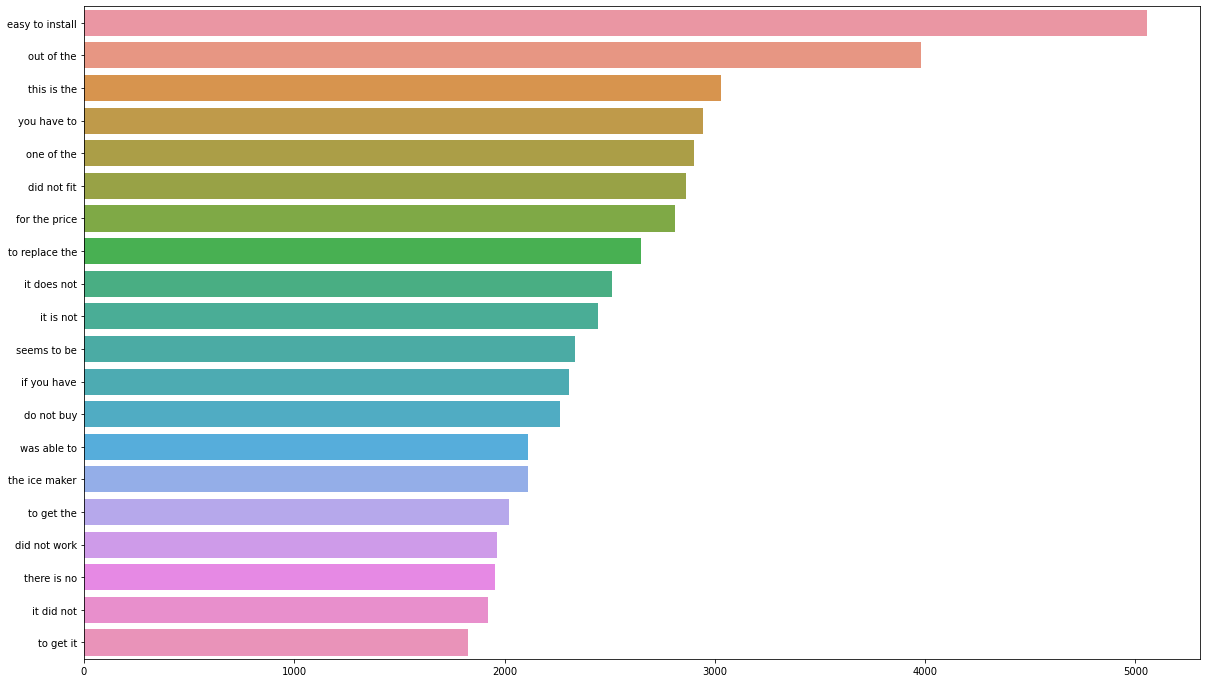

In [53]:
from sklearn.feature_extraction.text import CountVectorizer

def most_matches(corpus):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bow = vec.transform(corpus)
    sum_words = bow.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq

plt.figure(figsize=(20, 12))
biagram = most_matches(data.review)[:20]
x, y = map(list, zip(*biagram))
sns.barplot(x=y, y=x)
plt.show()


In [54]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(data.review, data.sentiment, test_size=.25)


In [55]:
train_y

154287    1
101327    0
146313    0
83024     0
169501    0
         ..
9468      1
33778     0
160522    1
210794    1
49831     1
Name: sentiment, Length: 166471, dtype: int64

In [56]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, oov_token="<00V>")
tokenizer.fit_on_texts(train_X)

train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)

train_X = pad_sequences(train_X, maxlen=100, padding="pre", truncating= 'post')
val_X = pad_sequences(val_X, maxlen=100, padding="pre", truncating= 'post')

print(train_X.shape)

(166471, 100)


In [57]:
from tensorflow.keras.layers import Dropout, Dense, Conv1D, Bidirectional, LSTM, Embedding
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Embedding(5000, 128, input_length=100))
model.add(Dropout(.4))
model.add(Conv1D(256, 7, activation="relu"))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16))
model.add(Dropout(.4))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="rmsprop",
             metrics=["accuracy"], loss="binary_crossentropy")

model.fit(train_X, train_y, batch_size=64,
         epochs=5, validation_data=(val_X, val_y))

Epoch 1/5
2602/2602 [==============================] - 1541s 583ms/step - loss: 0.3865 - accuracy: 0.8335 - val_loss: 0.3845 - val_accuracy: 0.8353
Epoch 2/5
2602/2602 [==============================] - 1351s 519ms/step - loss: 0.3339 - accuracy: 0.8624 - val_loss: 0.3310 - val_accuracy: 0.8565
Epoch 3/5
2602/2602 [==============================] - 1419s 545ms/step - loss: 0.3168 - accuracy: 0.8708 - val_loss: 0.3241 - val_accuracy: 0.8676
Epoch 4/5
2602/2602 [==============================] - 1427s 548ms/step - loss: 0.3058 - accuracy: 0.8763 - val_loss: 0.3198 - val_accuracy: 0.8635
Epoch 5/5
2602/2602 [==============================] - 1365s 525ms/step - loss: 0.2966 - accuracy: 0.8809 - val_loss: 0.3239 - val_accuracy: 0.8714


In [58]:
model.save("free_palestine.h5")

In [51]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
model1 = tf.keras.models.load_model('free_palestine.h5')



In [71]:
review_list = ['''Quality product but definitely underpowered compared to my expectations. I have a cheap one from harbor freight that is hotter and has better air flow. ''', "The first scene of the movie grabbed me at the first glance and took me to another world.", 
                "I don't like the way how the director decided to shoot this scene on that castle.", "I found the girl on the movie very hot and breath-taking."]

for text in review_list:
    text_seq = tokenizer.texts_to_sequences([preprocess_data(text)])
    text_seq = pad_sequences(text_seq, maxlen=100)

    pred = "Positive" if round(model.predict(text_seq)[0][0])==1 else "Negative"
    
    print("Review: {}".format(text))
    print("Sentiment: {}".format(pred))
    print()
    
    

1/1 [==============================] - 0s 75ms/step
Review: Quality product but definitely underpowered compared to my expectations. I have a cheap one from harbor freight that is hotter and has better air flow. 
Sentiment: Positive

1/1 [==============================] - 0s 71ms/step
Review: The first scene of the movie grabbed me at the first glance and took me to another world.
Sentiment: Negative

1/1 [==============================] - 0s 73ms/step
Review: I don't like the way how the director decided to shoot this scene on that castle.
Sentiment: Negative

1/1 [==============================] - 0s 69ms/step
Review: I found the girl on the movie very hot and breath-taking.
Sentiment: Negative

